In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

# Load raw dataset

In [2]:
# Load raw dataset
df = pd.read_csv("data/JCharis/emotion_dataset_raw.csv")

# Check for missing values
df.isnull().sum()

Emotion    0
Text       0
dtype: int64

# Check Emotion value counts

In [3]:
def plot_emotion_value_counts(data, column='Emotion'):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=column, data=data)
    ax.bar_label(ax.containers[0])
    plt.title("Value counts for Emotions")
    plt.show()

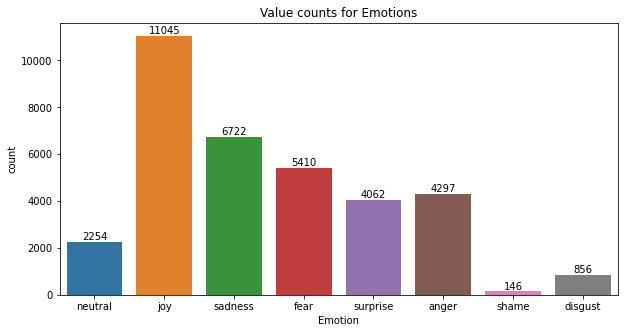

In [4]:
# Plot raw emotion value counts
plot_emotion_value_counts(df)

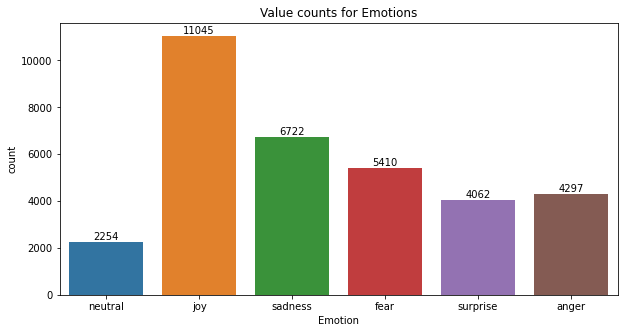

In [5]:
# Remove rows where value counts are less than 2000

emotion_value_counts = df.Emotion.value_counts()
emotions_to_drop = list(emotion_value_counts[emotion_value_counts < 2000].index.values)

df = df.loc[~df.Emotion.isin(emotions_to_drop)]

plot_emotion_value_counts(df)

# Text Cleaning

In [6]:
df['Clean_Text'] = df.Text.apply(nfx.remove_stopwords)
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_userhandles)
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_punctuations)
df.head(20)

,Emotion,Text,Clean_Text
0,neutral,Why ?,
1,joy,Sage Act upgrade on my to do list for tommorow.,Sage Act upgrade list tommorow
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,WAY HOMEGIRL BABY FUNERAL MAN HATE FUNERALS SH...
3,joy,Such an eye ! The true hazel eye-and so brill...,eye true hazel eyeand brilliant Regular feat...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,ugh babe hugggzzz u babe naamazed nga ako e...
5,fear,I'm expecting an extremely important phonecall...,Im expecting extremely important phonecall min...
6,sadness,.Couldnt wait to see them live. If missing th...,Couldnt wait live missing NH7 wasnt painful en...
7,surprise,maken Tip 2: Stop op een moment dat je het hel...,maken Tip 2: Stop op een moment dat je het hel...
8,surprise,En dan krijg je ff een cadeautje van een tweep...,En dan krijg je ff een cadeautje van een tweep...
9,surprise,@1116am Drummer Boy bij op verzoek van @BiemO...,Drummer Boy bij op verzoek van : welke ...


# Sentiment Analysis

In [7]:
from textblob import TextBlob

def get_sentiment(text:str)->str:
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        result = 'Positive'
    elif sentiment < 0:
        result = 'Negative'
    else:
        result = 'Neutral'
    return result

In [8]:
# Add Sentiment column
df["Sentiment"] = df.Text.apply(get_sentiment)

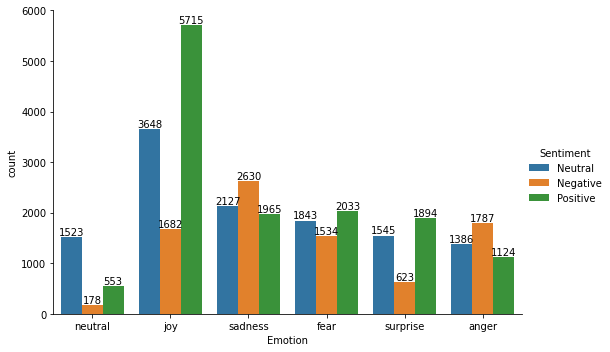

In [9]:
# Compare Emotion vs Sentiment
grid = sns.catplot(x='Emotion', hue='Sentiment', data=df, kind='count', aspect=1.5)
ax = grid.axes[0, 0]
for container in ax.containers:
    ax.bar_label(container)
plt.show()

# Keyword extraction

In [10]:
from collections import Counter
from wordcloud import WordCloud

def extract_keywords(text:str, num:int = 50)->dict:
    tokens = [token for token in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

def plot_keywords(keywords_dict: dict, emotion:str):
    keyword_df = pd.DataFrame(keywords_dict.items(), columns=['token', 'count'])
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x='token', y='count', data=keyword_df)
    ax.bar_label(ax.containers[0])
    plt.xticks(rotation=45)
    plt.title("Keyword counts for " + emotion)
    plt.show()

def plot_wordcloud(docx: str, emotion:str):
    emotion_wordcloud = WordCloud().generate(docx)
    plt.figure(figsize=(20, 10))
    plt.imshow(emotion_wordcloud, interpolation='bilinear')
    plt.title("Word cloud for " + emotion)
    plt.axis('off')
    plt.show()
    

In [11]:
# Get list of emotions
emotion_list = df.Emotion.unique().tolist()

In [12]:
# Extract keywords
emotion_keywords_dict = {}
emotion_docx = {}

for emotion in emotion_list:
    text_list = df[df["Emotion"] == emotion]["Clean_Text"].tolist()
    docx = ' '.join(text_list)
    keywords = extract_keywords(docx)
    emotion_keywords_dict[emotion] = keywords
    emotion_docx[emotion] = docx

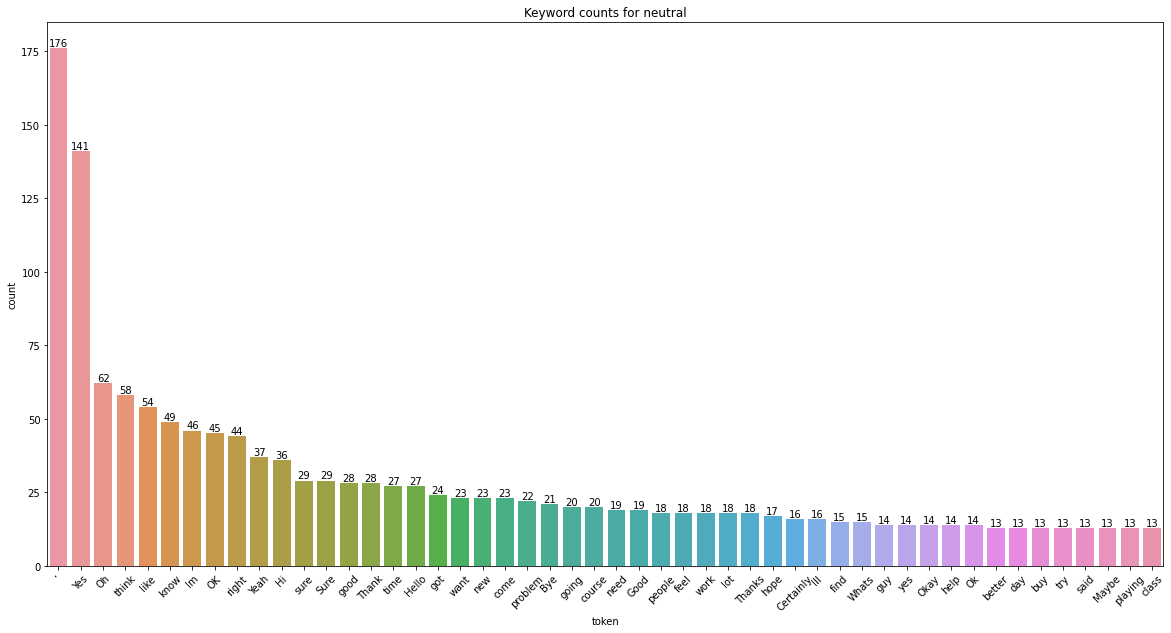

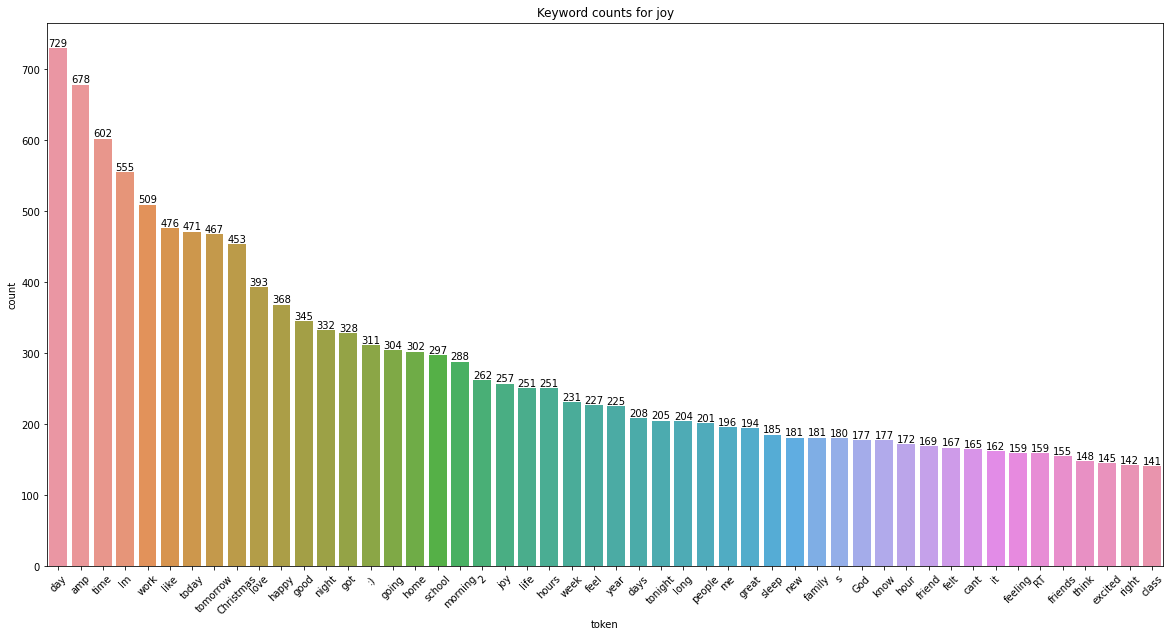

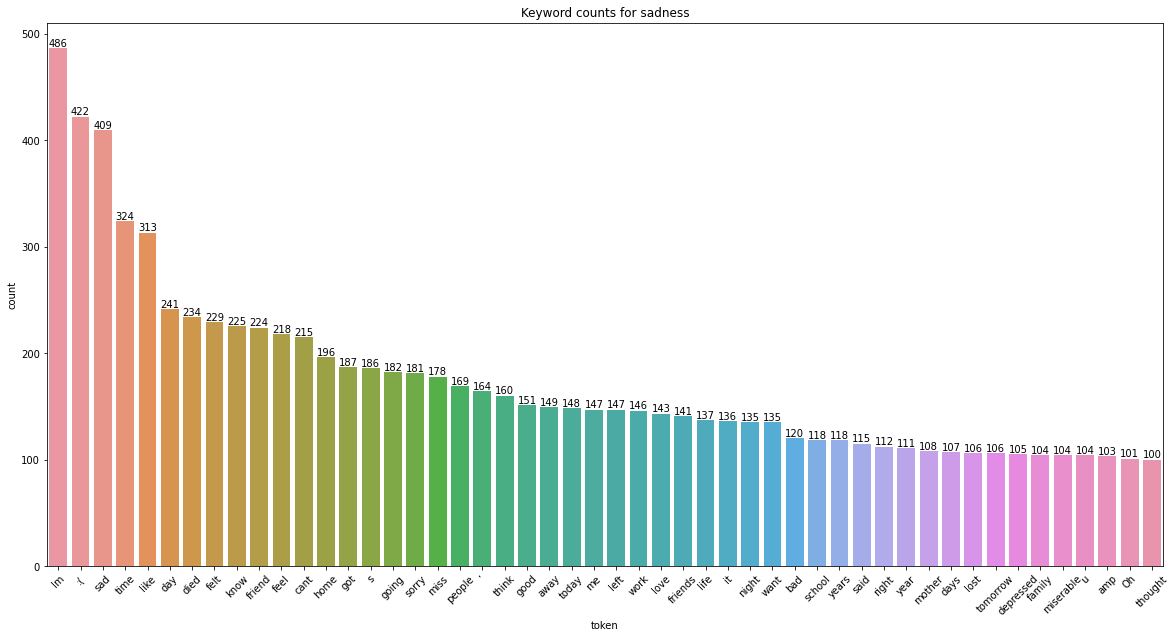

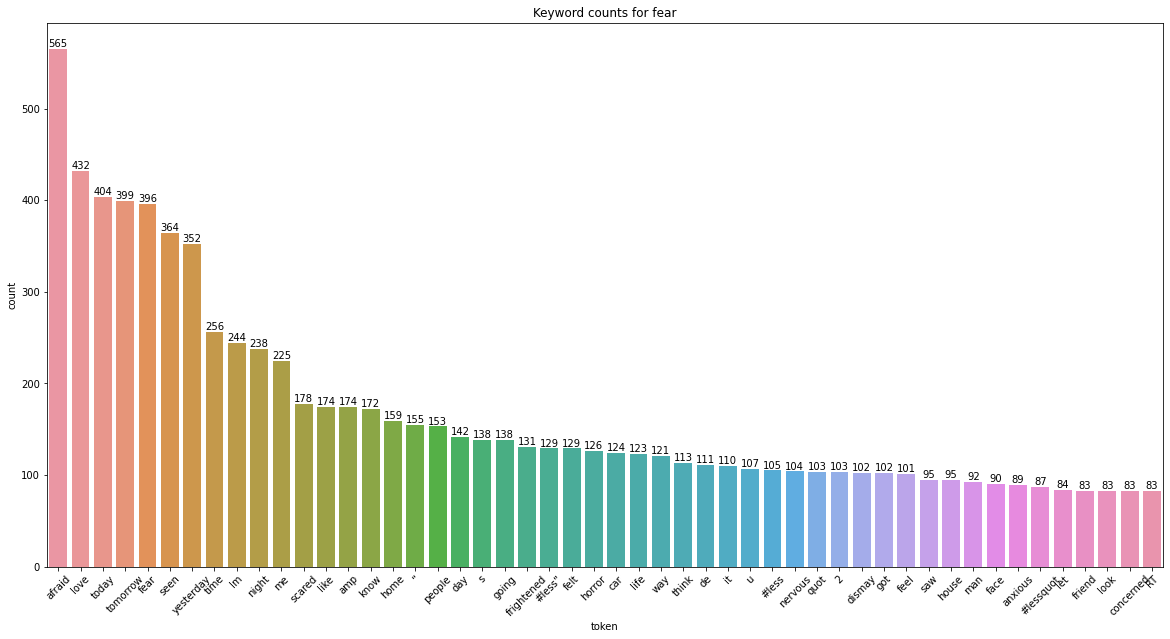

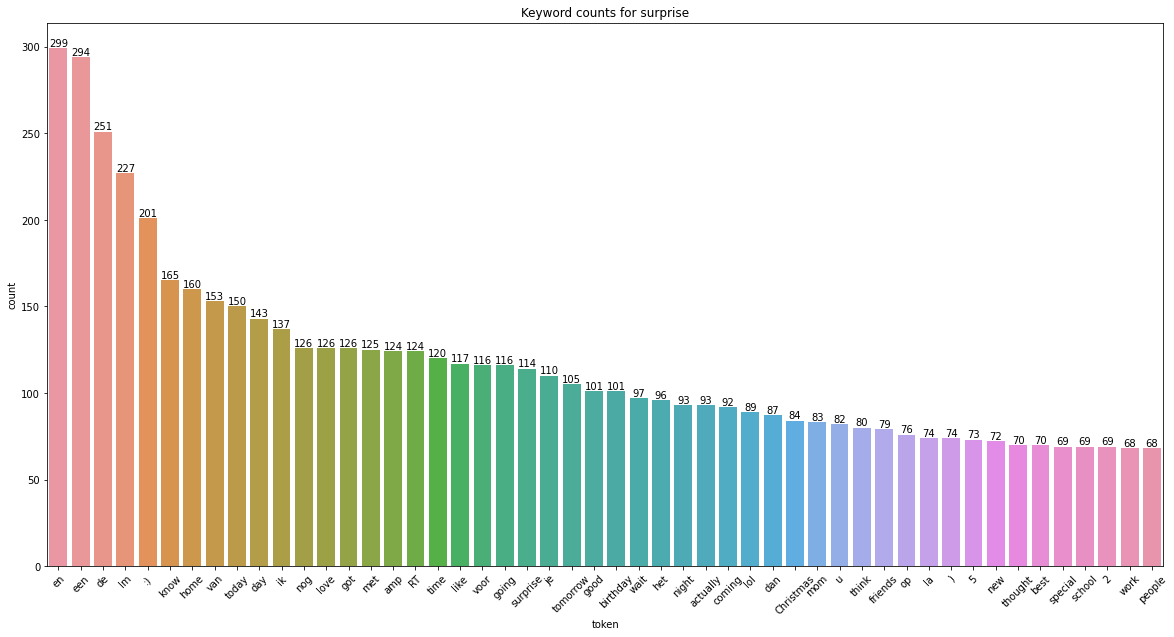

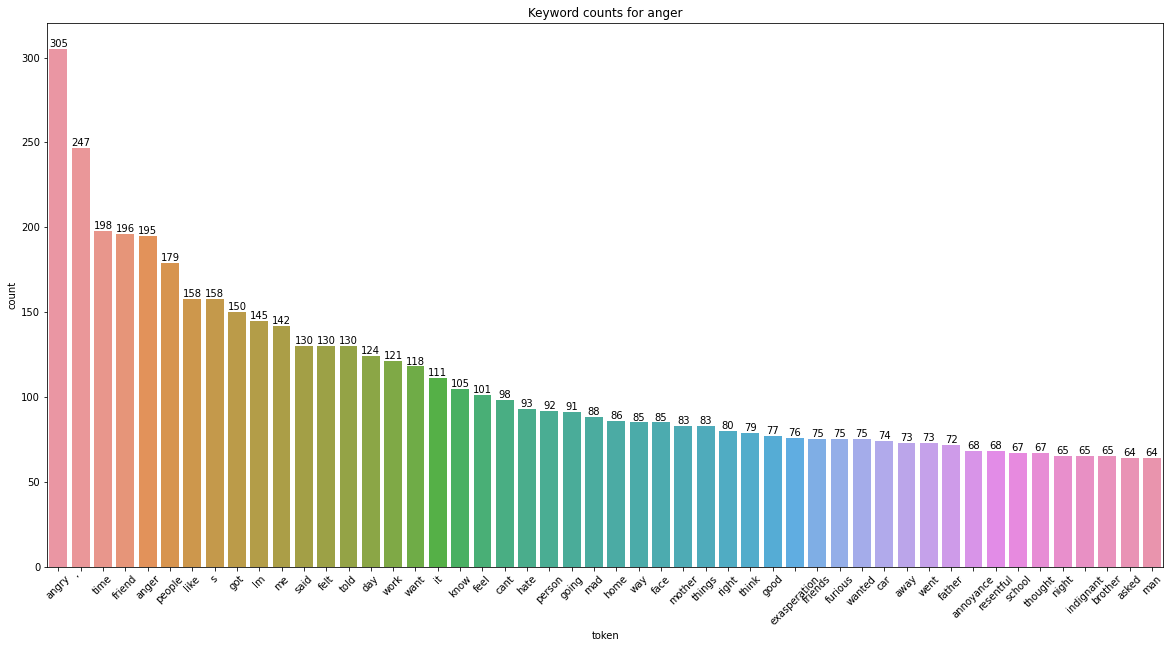

In [13]:
# Plot keyword counts
for emotion in emotion_keywords_dict:
    plot_keywords(emotion_keywords_dict[emotion], emotion)

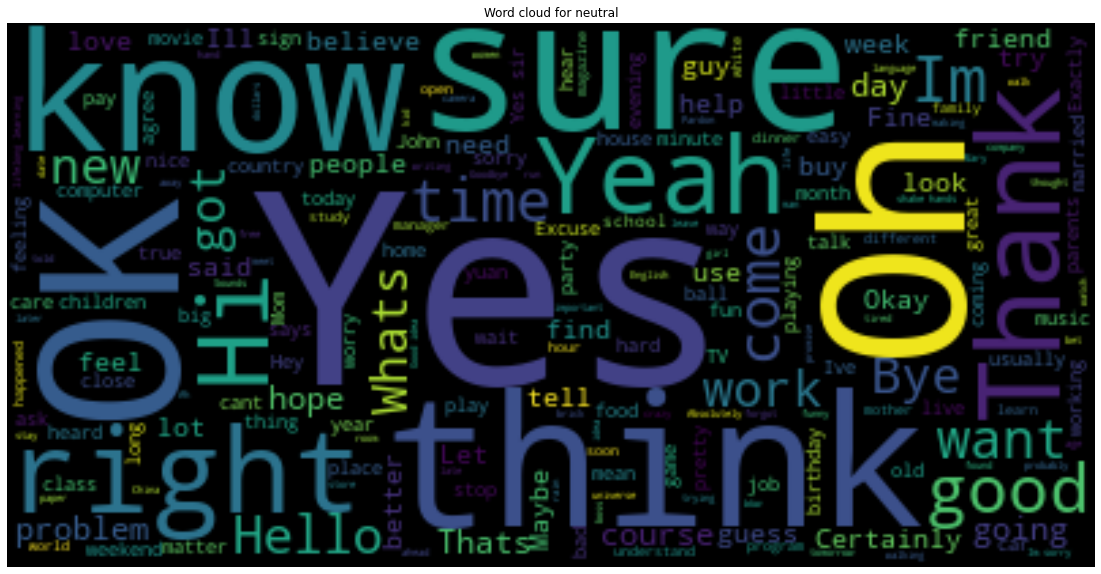

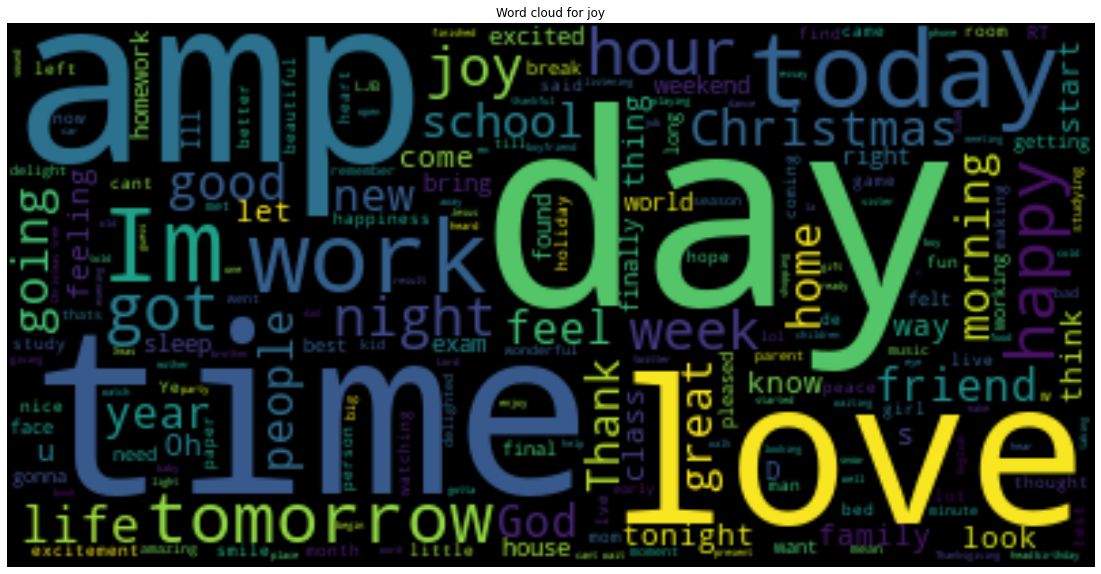

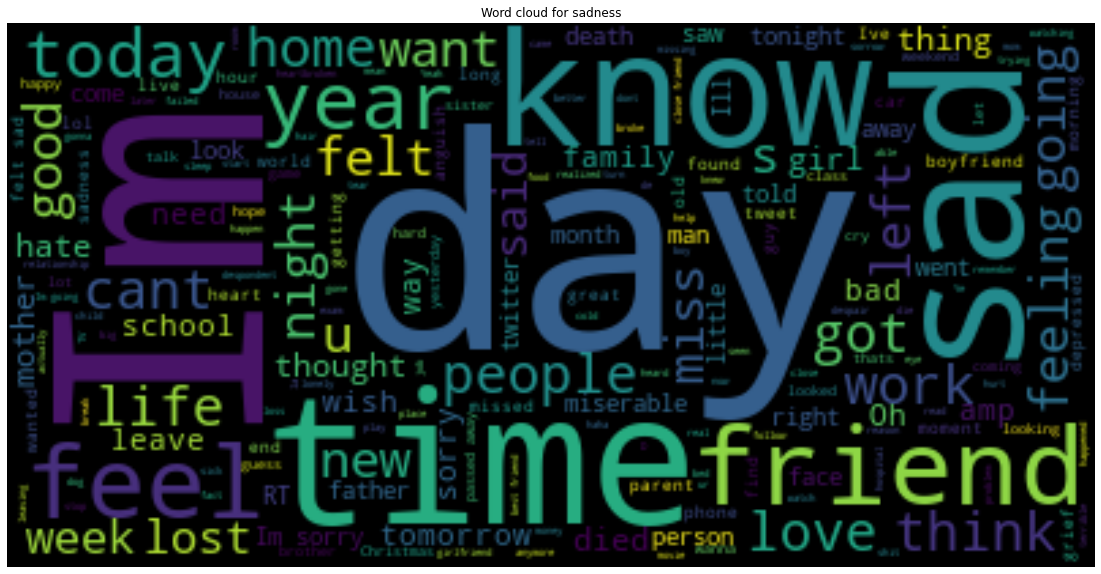

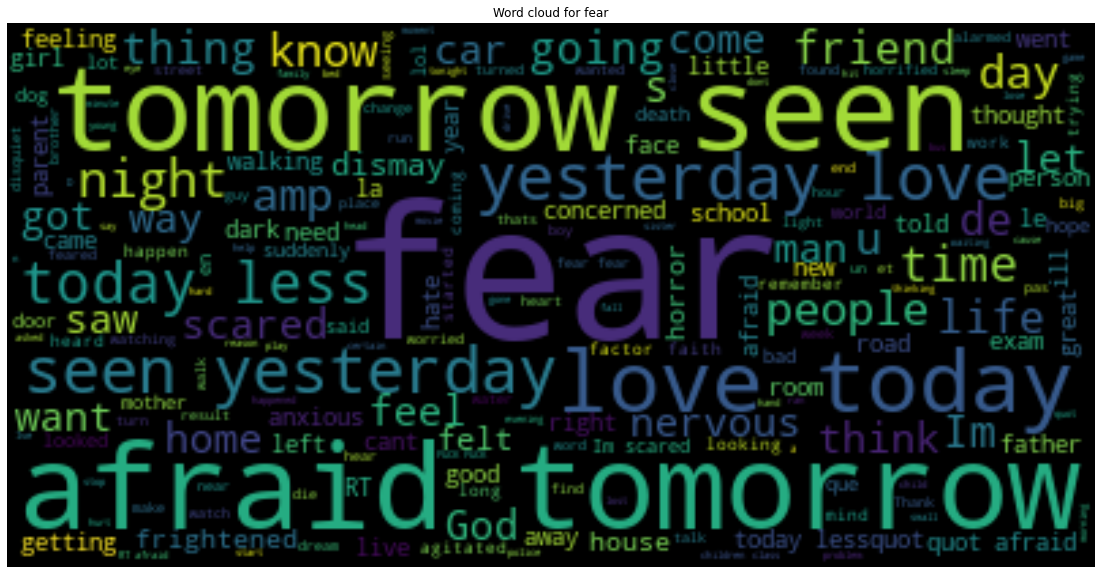

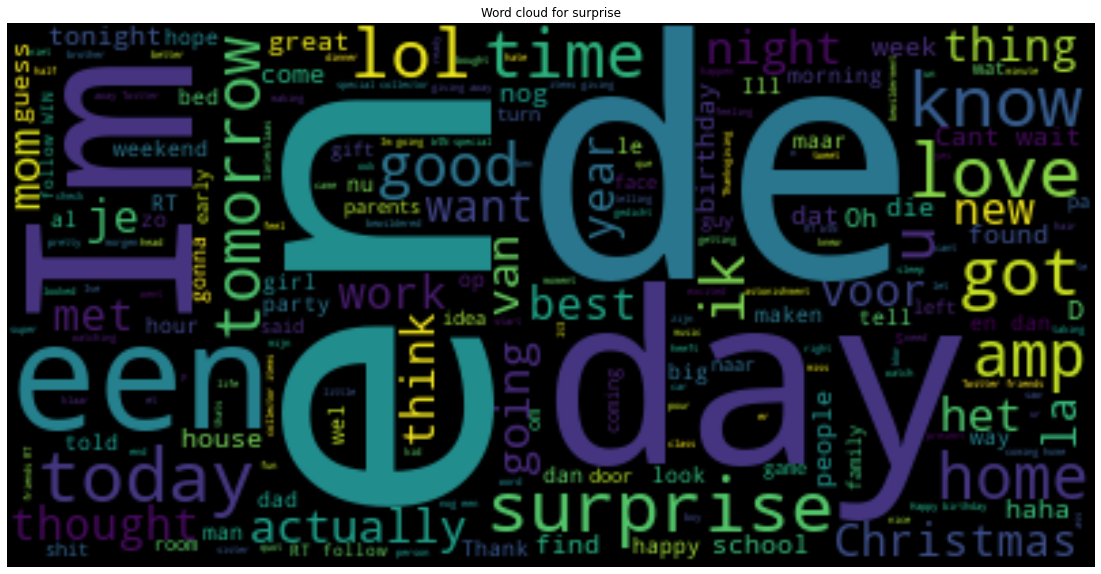

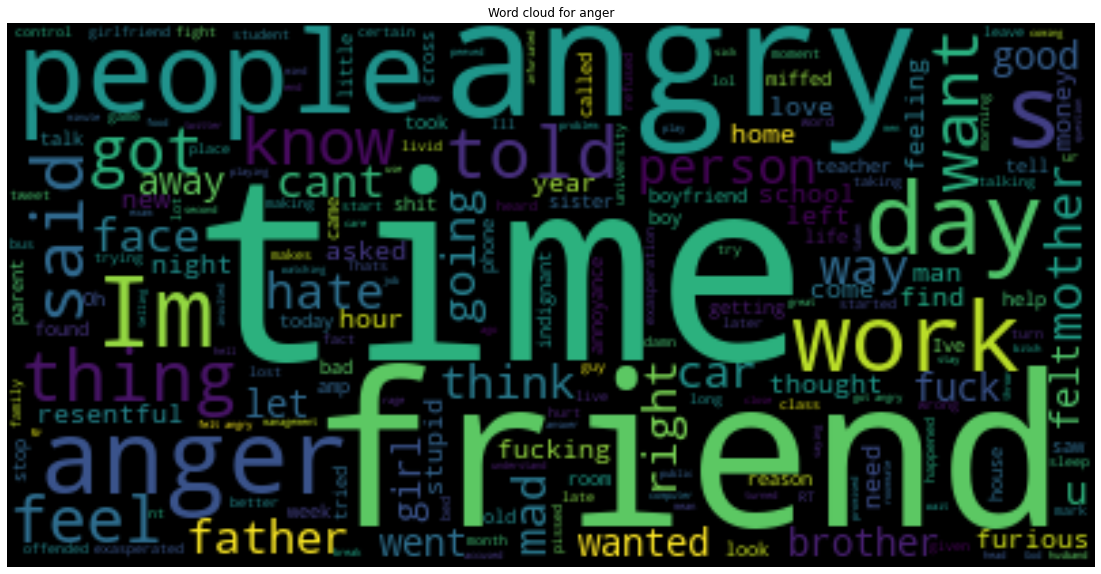

In [14]:
# Plot word clouds
for emotion in emotion_docx:
    plot_wordcloud(emotion_docx[emotion], emotion)

# Split data

In [15]:
# Extract features and labels
X_features = df.Clean_Text
y_labels = df.Emotion

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3, random_state=2)

# Logistic Regression Model

In [17]:
from sklearn.pipeline import Pipeline

In [18]:
# Logistic Regression Pipeline
lr_pipe = Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression(solver='liblinear'))])

# Train and fit data
lr_pipe.fit(X_train, y_train)

lr_y_pred = lr_pipe.predict(y_test)

In [19]:
# Plot results
lr_test_df = pd.concat([X_test, y_test], axis=1)
lr_test_df['Pred_Emotion'] = lr_y_pred.tolist()
lr_test_df.head()

,Clean_Text,Emotion,Pred_Emotion
30639,B4 u life afraid loneliness amp u life scared ...,fear,fear
1411,Thats able extract Bojans open letter Gazzet...,sadness,sadness
34098,Misbah couldnt resist you ruin it people hate ...,sadness,sadness
23898,Im thinking same liein tomorrow whilst well ...,joy,joy
9606,beach BRAND NEW BFFnd dnt wana b seperated ha ...,sadness,sadness


In [20]:
def plot_model_results(test_df, classes, model_name):
    index = np.arange(len(classes))
    fig, ax = plt.subplots()

    bar_width = 0.35

    actual_counts = test_df.Emotion.value_counts()
    pred_counts = test_df.Pred_Emotion.value_counts()

    actual_rects = ax.bar(index, actual_counts.tolist(), bar_width, color='b', label='Actual')
    pred_rects = ax.bar(index + bar_width, pred_counts.tolist(), bar_width, color='r', label='Predicted')

    ax.set_xlabel('Emotion')
    ax.set_ylabel('counts')
    ax.set_title('Results using ' + model_name)

    ax.set_xticks(index + bar_width / 2)

    ax.set_xticklabels(classes)

    ax.legend()
    plt.show()

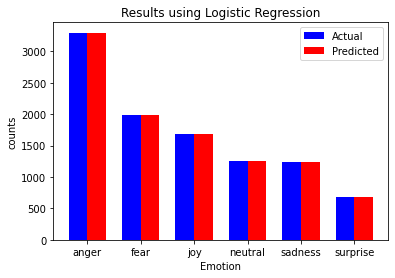

In [21]:
plot_model_results(lr_test_df, lr_pipe.classes_, "Logistic Regression")

# Naive Bayes

In [22]:
cv = CountVectorizer()
x = cv.fit_transform(X_features)
X_train_mat, X_test_mat, y_train, y_test = train_test_split(x, y_labels,test_size=0.3,random_state=2)
nv_model = MultinomialNB()
nv_model.fit(X_train_mat, y_train)
nv_model.score(X_test_mat, y_test)

0.5836046167505179

In [23]:
nv_y_pred = nv_model.predict(X_test_mat)
nv_test_df = pd.concat([X_test, y_test], axis=1)
nv_test_df['Pred_Emotion'] = nv_y_pred
nv_test_df.head()

,Clean_Text,Emotion,Pred_Emotion
30639,B4 u life afraid loneliness amp u life scared ...,fear,fear
1411,Thats able extract Bojans open letter Gazzet...,sadness,joy
34098,Misbah couldnt resist you ruin it people hate ...,sadness,sadness
23898,Im thinking same liein tomorrow whilst well ...,joy,joy
9606,beach BRAND NEW BFFnd dnt wana b seperated ha ...,sadness,joy


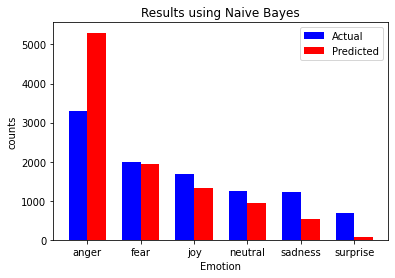

In [24]:
plot_model_results(nv_test_df, nv_model.classes_, "Naive Bayes")